In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from tqdm import tqdm

In [2]:
import os

# Define the folder name where you want to save the model
folder_name = 'image_classification'

# Create the folder if it doesn't exist
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Define the file path for the model's state dictionary
file_path = os.path.join(folder_name, 'model_state_dict.pth')

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])

In [5]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
validation_set_len = 5000
train_dataset_len = len(train_dataset) - validation_set_len
train_dataset , validation_dataset = random_split(train_dataset ,[train_dataset_len , validation_set_len])



100%|██████████| 170498071/170498071 [00:05<00:00, 29436706.26it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

64
torch.Size([3, 32, 32])


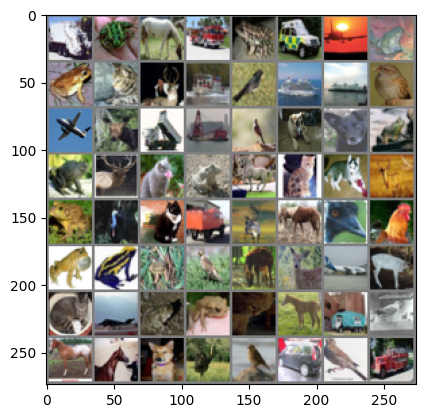

tensor([9, 6, 7, 9, 6, 1, 0, 6, 6, 3, 4, 8, 2, 8, 8, 2, 0, 4, 9, 8, 2, 5, 5, 6,
        6, 4, 3, 6, 7, 3, 5, 4, 6, 2, 3, 9, 4, 7, 2, 2, 6, 6, 6, 2, 4, 4, 0, 4,
        3, 0, 6, 6, 3, 7, 9, 2, 7, 7, 5, 2, 2, 1, 2, 9])


In [7]:
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of images
for images, labels in train_loader:
    print(len(images))
    # Show images
    print(images[0].shape)
    imshow(torchvision.utils.make_grid(images))
    print(labels)
    break  # Display only the first batch of images


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images = images
        labels = labels
        out = self(images)
        loss = F.cross_entropy(out, labels)
        accu = self.accuracy(out, labels)
        return loss, accu

    def validation_step(self, batch):
        images, labels = batch
        images = images
        labels = labels
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = self.accuracy(out, labels)
        return {'Loss': loss.detach(), 'Accuracy': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['Loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['Accuracy'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'Loss': epoch_loss.item(), 'Accuracy': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch :", epoch + 1)
        print(f'Train Accuracy: {result["train_accuracy"] * 100:.2f}% Validation Accuracy: {result["Accuracy"] * 100:.2f}%')
        print(f'Train Loss: {result["train_loss"]:.4f} Validation Loss: {result["Loss"]:.4f}')

    @torch.no_grad()
    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))


BUILDING THE MODEL

In [12]:
class ImageClassifier(ImageClassificationBase):
  def __init__(self, ):
      super(ImageClassifier, self).__init__()
      self.network = nn.Sequential(
          nn.Conv2d(3,32,kernel_size=3 , padding=1) ,
          nn.ReLU(),
          nn.Conv2d(32,64,kernel_size=3 , stride=1 , padding=1) ,
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.BatchNorm2d(64),
          nn.Conv2d(64,128,kernel_size=3 , stride=1 , padding=1) ,
          nn.ReLU(),
          nn.Conv2d(128,128,kernel_size=3 , stride=1 , padding=1) ,
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.BatchNorm2d(128),
          nn.Conv2d(128,256,kernel_size=3 , stride=1 , padding=1) ,
          nn.ReLU(),
          nn.Conv2d(256,256,kernel_size=3 , stride=1 , padding=1) ,
          nn.ReLU(),
          nn.MaxPool2d(2,2),
          nn.BatchNorm2d(256),
          nn.Flatten(),
          nn.Linear(256*4*4 , 1024),
          nn.ReLU(),
          nn.Linear(1024, 512),
          nn.ReLU(),
          nn.Linear(512,10))
  def forward(self,x):
    output = self.network(x)
    return output







In [13]:
model = ImageClassifier()
model.to(device)

ImageClassifier(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

In [14]:
train_loader = [(images.to(device), labels.to(device)) for images, labels in train_loader]
validation_loader = [(images.to(device), labels.to(device)) for images, labels in validation_loader]

In [15]:
@torch.no_grad()
def evaluate(model, data_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in data_loader]
    return model.validation_epoch_end(outputs)

def fit(model, train_loader, val_loader,epochs=150,learning_rate=0.001):
    best_valid = None
    history = []
    optimizer = torch.optim.Adam(model.parameters(), learning_rate,weight_decay=0.0005)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_accuracy = []
        for batch in tqdm(train_loader):

            loss,accu = model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(accu)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        model.epoch_end(epoch, result)
        if(best_valid == None or best_valid<result['Accuracy']):
            best_valid=result['Accuracy']
            torch.save(model.state_dict(), file_path)
        history.append(result)
    return history
history = fit(model, train_loader, validation_loader)
# history = fit(resnet, train_loader, validation_loader)

100%|██████████| 704/704 [00:19<00:00, 35.54it/s]


Epoch : 1
Train Accuracy: 59.27% Validation Accuracy: 69.84%
Train Loss: 1.1498 Validation Loss: 0.8635


100%|██████████| 704/704 [00:09<00:00, 74.11it/s]


Epoch : 2
Train Accuracy: 74.45% Validation Accuracy: 74.47%
Train Loss: 0.7385 Validation Loss: 0.7513


100%|██████████| 704/704 [00:09<00:00, 73.64it/s]


Epoch : 3
Train Accuracy: 79.86% Validation Accuracy: 77.29%
Train Loss: 0.5843 Validation Loss: 0.6860


100%|██████████| 704/704 [00:10<00:00, 70.31it/s]


Epoch : 4
Train Accuracy: 83.36% Validation Accuracy: 79.67%
Train Loss: 0.4835 Validation Loss: 0.6373


100%|██████████| 704/704 [00:09<00:00, 72.34it/s]


Epoch : 5
Train Accuracy: 86.19% Validation Accuracy: 79.92%
Train Loss: 0.4021 Validation Loss: 0.6404


100%|██████████| 704/704 [00:09<00:00, 71.77it/s]


Epoch : 6
Train Accuracy: 87.91% Validation Accuracy: 79.77%
Train Loss: 0.3475 Validation Loss: 0.6568


100%|██████████| 704/704 [00:09<00:00, 70.94it/s]


Epoch : 7
Train Accuracy: 89.41% Validation Accuracy: 80.46%
Train Loss: 0.3008 Validation Loss: 0.6762


100%|██████████| 704/704 [00:09<00:00, 70.78it/s]


Epoch : 8
Train Accuracy: 91.02% Validation Accuracy: 80.72%
Train Loss: 0.2582 Validation Loss: 0.6587


100%|██████████| 704/704 [00:10<00:00, 69.54it/s]


Epoch : 9
Train Accuracy: 92.01% Validation Accuracy: 80.76%
Train Loss: 0.2286 Validation Loss: 0.6591


100%|██████████| 704/704 [00:09<00:00, 71.92it/s]


Epoch : 10
Train Accuracy: 92.81% Validation Accuracy: 81.72%
Train Loss: 0.2061 Validation Loss: 0.6745


100%|██████████| 704/704 [00:09<00:00, 72.34it/s]


Epoch : 11
Train Accuracy: 93.40% Validation Accuracy: 81.88%
Train Loss: 0.1873 Validation Loss: 0.6834


100%|██████████| 704/704 [00:09<00:00, 72.12it/s]


Epoch : 12
Train Accuracy: 93.94% Validation Accuracy: 81.67%
Train Loss: 0.1730 Validation Loss: 0.7175


100%|██████████| 704/704 [00:09<00:00, 71.96it/s]


Epoch : 13
Train Accuracy: 94.07% Validation Accuracy: 80.42%
Train Loss: 0.1707 Validation Loss: 0.7168


100%|██████████| 704/704 [00:09<00:00, 71.82it/s]


Epoch : 14
Train Accuracy: 94.58% Validation Accuracy: 81.98%
Train Loss: 0.1540 Validation Loss: 0.6902


100%|██████████| 704/704 [00:09<00:00, 71.50it/s]


Epoch : 15
Train Accuracy: 94.85% Validation Accuracy: 80.91%
Train Loss: 0.1484 Validation Loss: 0.7877


100%|██████████| 704/704 [00:09<00:00, 71.56it/s]


Epoch : 16
Train Accuracy: 95.02% Validation Accuracy: 81.57%
Train Loss: 0.1436 Validation Loss: 0.7011


100%|██████████| 704/704 [00:09<00:00, 71.84it/s]


Epoch : 17
Train Accuracy: 95.21% Validation Accuracy: 82.52%
Train Loss: 0.1372 Validation Loss: 0.6956


100%|██████████| 704/704 [00:09<00:00, 72.01it/s]


Epoch : 18
Train Accuracy: 95.21% Validation Accuracy: 82.81%
Train Loss: 0.1354 Validation Loss: 0.7054


100%|██████████| 704/704 [00:09<00:00, 72.05it/s]


Epoch : 19
Train Accuracy: 95.14% Validation Accuracy: 82.32%
Train Loss: 0.1384 Validation Loss: 0.7125


100%|██████████| 704/704 [00:09<00:00, 71.97it/s]


Epoch : 20
Train Accuracy: 95.92% Validation Accuracy: 81.90%
Train Loss: 0.1173 Validation Loss: 0.7609


100%|██████████| 704/704 [00:09<00:00, 71.64it/s]


Epoch : 21
Train Accuracy: 95.35% Validation Accuracy: 83.01%
Train Loss: 0.1330 Validation Loss: 0.6939


100%|██████████| 704/704 [00:09<00:00, 71.68it/s]


Epoch : 22
Train Accuracy: 95.63% Validation Accuracy: 81.80%
Train Loss: 0.1277 Validation Loss: 0.7503


100%|██████████| 704/704 [00:09<00:00, 71.63it/s]


Epoch : 23
Train Accuracy: 95.76% Validation Accuracy: 82.58%
Train Loss: 0.1196 Validation Loss: 0.7195


100%|██████████| 704/704 [00:09<00:00, 71.49it/s]


Epoch : 24
Train Accuracy: 95.92% Validation Accuracy: 81.53%
Train Loss: 0.1164 Validation Loss: 0.7454


100%|██████████| 704/704 [00:09<00:00, 71.97it/s]


Epoch : 25
Train Accuracy: 95.64% Validation Accuracy: 82.56%
Train Loss: 0.1232 Validation Loss: 0.7269


100%|██████████| 704/704 [00:09<00:00, 72.14it/s]


Epoch : 26
Train Accuracy: 96.15% Validation Accuracy: 82.30%
Train Loss: 0.1109 Validation Loss: 0.7559


100%|██████████| 704/704 [00:09<00:00, 72.03it/s]


Epoch : 27
Train Accuracy: 95.79% Validation Accuracy: 82.26%
Train Loss: 0.1195 Validation Loss: 0.7344


100%|██████████| 704/704 [00:09<00:00, 72.07it/s]


Epoch : 28
Train Accuracy: 96.10% Validation Accuracy: 81.23%
Train Loss: 0.1127 Validation Loss: 0.7879


100%|██████████| 704/704 [00:09<00:00, 71.83it/s]


Epoch : 29
Train Accuracy: 96.30% Validation Accuracy: 82.08%
Train Loss: 0.1073 Validation Loss: 0.7620


100%|██████████| 704/704 [00:09<00:00, 71.81it/s]


Epoch : 30
Train Accuracy: 95.95% Validation Accuracy: 82.89%
Train Loss: 0.1145 Validation Loss: 0.7147


100%|██████████| 704/704 [00:09<00:00, 71.85it/s]


Epoch : 31
Train Accuracy: 96.30% Validation Accuracy: 82.06%
Train Loss: 0.1065 Validation Loss: 0.7731


100%|██████████| 704/704 [00:09<00:00, 72.18it/s]


Epoch : 32
Train Accuracy: 96.22% Validation Accuracy: 81.29%
Train Loss: 0.1078 Validation Loss: 0.7915


100%|██████████| 704/704 [00:09<00:00, 72.45it/s]


Epoch : 33
Train Accuracy: 96.26% Validation Accuracy: 82.63%
Train Loss: 0.1106 Validation Loss: 0.7680


100%|██████████| 704/704 [00:09<00:00, 72.10it/s]


Epoch : 34
Train Accuracy: 96.40% Validation Accuracy: 82.48%
Train Loss: 0.1041 Validation Loss: 0.7307


100%|██████████| 704/704 [00:09<00:00, 71.93it/s]


Epoch : 35
Train Accuracy: 96.27% Validation Accuracy: 81.67%
Train Loss: 0.1073 Validation Loss: 0.7489


100%|██████████| 704/704 [00:09<00:00, 72.05it/s]


Epoch : 36
Train Accuracy: 96.84% Validation Accuracy: 82.46%
Train Loss: 0.0914 Validation Loss: 0.7708


100%|██████████| 704/704 [00:09<00:00, 71.88it/s]


Epoch : 37
Train Accuracy: 96.20% Validation Accuracy: 82.91%
Train Loss: 0.1108 Validation Loss: 0.7193


100%|██████████| 704/704 [00:09<00:00, 72.07it/s]


Epoch : 38
Train Accuracy: 96.23% Validation Accuracy: 82.08%
Train Loss: 0.1062 Validation Loss: 0.7657


100%|██████████| 704/704 [00:09<00:00, 72.28it/s]


Epoch : 39
Train Accuracy: 96.61% Validation Accuracy: 82.71%
Train Loss: 0.0983 Validation Loss: 0.7415


100%|██████████| 704/704 [00:09<00:00, 72.37it/s]


Epoch : 40
Train Accuracy: 96.58% Validation Accuracy: 82.95%
Train Loss: 0.0986 Validation Loss: 0.7229


100%|██████████| 704/704 [00:09<00:00, 72.32it/s]


Epoch : 41
Train Accuracy: 96.57% Validation Accuracy: 82.22%
Train Loss: 0.0986 Validation Loss: 0.7443


100%|██████████| 704/704 [00:09<00:00, 72.25it/s]


Epoch : 42
Train Accuracy: 96.64% Validation Accuracy: 82.20%
Train Loss: 0.0962 Validation Loss: 0.7663


100%|██████████| 704/704 [00:09<00:00, 72.20it/s]


Epoch : 43
Train Accuracy: 96.79% Validation Accuracy: 83.05%
Train Loss: 0.0946 Validation Loss: 0.7422


100%|██████████| 704/704 [00:09<00:00, 72.07it/s]


Epoch : 44
Train Accuracy: 96.37% Validation Accuracy: 82.71%
Train Loss: 0.1068 Validation Loss: 0.7340


100%|██████████| 704/704 [00:09<00:00, 71.87it/s]


Epoch : 45
Train Accuracy: 96.48% Validation Accuracy: 82.00%
Train Loss: 0.1015 Validation Loss: 0.7561


100%|██████████| 704/704 [00:09<00:00, 72.02it/s]


Epoch : 46
Train Accuracy: 97.09% Validation Accuracy: 81.88%
Train Loss: 0.0830 Validation Loss: 0.7869


100%|██████████| 704/704 [00:09<00:00, 72.20it/s]


Epoch : 47
Train Accuracy: 96.66% Validation Accuracy: 82.75%
Train Loss: 0.0972 Validation Loss: 0.7633


100%|██████████| 704/704 [00:09<00:00, 72.48it/s]


Epoch : 48
Train Accuracy: 96.67% Validation Accuracy: 81.65%
Train Loss: 0.0963 Validation Loss: 0.7992


100%|██████████| 704/704 [00:09<00:00, 72.35it/s]


Epoch : 49
Train Accuracy: 96.78% Validation Accuracy: 82.10%
Train Loss: 0.0945 Validation Loss: 0.7951


100%|██████████| 704/704 [00:09<00:00, 72.39it/s]


Epoch : 50
Train Accuracy: 96.94% Validation Accuracy: 81.90%
Train Loss: 0.0913 Validation Loss: 0.8302


100%|██████████| 704/704 [00:09<00:00, 72.21it/s]


Epoch : 51
Train Accuracy: 96.62% Validation Accuracy: 83.15%
Train Loss: 0.0972 Validation Loss: 0.7312


100%|██████████| 704/704 [00:09<00:00, 71.99it/s]


Epoch : 52
Train Accuracy: 96.94% Validation Accuracy: 82.91%
Train Loss: 0.0890 Validation Loss: 0.7964


100%|██████████| 704/704 [00:09<00:00, 72.01it/s]


Epoch : 53
Train Accuracy: 96.76% Validation Accuracy: 82.69%
Train Loss: 0.0939 Validation Loss: 0.7367


100%|██████████| 704/704 [00:09<00:00, 72.18it/s]


Epoch : 54
Train Accuracy: 96.69% Validation Accuracy: 81.25%
Train Loss: 0.0951 Validation Loss: 0.8237


100%|██████████| 704/704 [00:09<00:00, 72.45it/s]


Epoch : 55
Train Accuracy: 96.80% Validation Accuracy: 82.34%
Train Loss: 0.0931 Validation Loss: 0.7595


100%|██████████| 704/704 [00:09<00:00, 72.55it/s]


Epoch : 56
Train Accuracy: 97.13% Validation Accuracy: 82.38%
Train Loss: 0.0852 Validation Loss: 0.7527


100%|██████████| 704/704 [00:09<00:00, 72.26it/s]


Epoch : 57
Train Accuracy: 96.68% Validation Accuracy: 82.44%
Train Loss: 0.0947 Validation Loss: 0.7378


100%|██████████| 704/704 [00:09<00:00, 72.05it/s]


Epoch : 58
Train Accuracy: 96.96% Validation Accuracy: 82.04%
Train Loss: 0.0862 Validation Loss: 0.7827


100%|██████████| 704/704 [00:09<00:00, 72.22it/s]


Epoch : 59
Train Accuracy: 96.91% Validation Accuracy: 82.32%
Train Loss: 0.0912 Validation Loss: 0.7907


100%|██████████| 704/704 [00:09<00:00, 72.08it/s]


Epoch : 60
Train Accuracy: 97.04% Validation Accuracy: 82.71%
Train Loss: 0.0854 Validation Loss: 0.7800


100%|██████████| 704/704 [00:09<00:00, 72.35it/s]


Epoch : 61
Train Accuracy: 96.85% Validation Accuracy: 82.34%
Train Loss: 0.0903 Validation Loss: 0.7948


100%|██████████| 704/704 [00:09<00:00, 72.41it/s]


Epoch : 62
Train Accuracy: 96.97% Validation Accuracy: 82.24%
Train Loss: 0.0867 Validation Loss: 0.7446


100%|██████████| 704/704 [00:09<00:00, 72.48it/s]


Epoch : 63
Train Accuracy: 96.82% Validation Accuracy: 82.59%
Train Loss: 0.0933 Validation Loss: 0.7190


100%|██████████| 704/704 [00:09<00:00, 72.51it/s]


Epoch : 64
Train Accuracy: 97.19% Validation Accuracy: 82.10%
Train Loss: 0.0818 Validation Loss: 0.7776


100%|██████████| 704/704 [00:09<00:00, 72.27it/s]


Epoch : 65
Train Accuracy: 96.86% Validation Accuracy: 82.95%
Train Loss: 0.0897 Validation Loss: 0.7534


100%|██████████| 704/704 [00:09<00:00, 72.38it/s]


Epoch : 66
Train Accuracy: 97.09% Validation Accuracy: 83.01%
Train Loss: 0.0850 Validation Loss: 0.7594


100%|██████████| 704/704 [00:09<00:00, 72.22it/s]


Epoch : 67
Train Accuracy: 96.78% Validation Accuracy: 82.77%
Train Loss: 0.0929 Validation Loss: 0.7593


100%|██████████| 704/704 [00:09<00:00, 72.19it/s]


Epoch : 68
Train Accuracy: 96.96% Validation Accuracy: 82.54%
Train Loss: 0.0889 Validation Loss: 0.7751


100%|██████████| 704/704 [00:09<00:00, 72.39it/s]


Epoch : 69
Train Accuracy: 97.18% Validation Accuracy: 83.01%
Train Loss: 0.0853 Validation Loss: 0.7690


100%|██████████| 704/704 [00:09<00:00, 72.57it/s]


Epoch : 70
Train Accuracy: 97.27% Validation Accuracy: 82.93%
Train Loss: 0.0798 Validation Loss: 0.7546


100%|██████████| 704/704 [00:09<00:00, 72.55it/s]


Epoch : 71
Train Accuracy: 96.91% Validation Accuracy: 82.59%
Train Loss: 0.0910 Validation Loss: 0.7514


100%|██████████| 704/704 [00:09<00:00, 72.46it/s]


Epoch : 72
Train Accuracy: 97.09% Validation Accuracy: 83.07%
Train Loss: 0.0844 Validation Loss: 0.7575


100%|██████████| 704/704 [00:09<00:00, 72.37it/s]


Epoch : 73
Train Accuracy: 97.19% Validation Accuracy: 83.13%
Train Loss: 0.0805 Validation Loss: 0.7665


100%|██████████| 704/704 [00:09<00:00, 72.33it/s]


Epoch : 74
Train Accuracy: 96.90% Validation Accuracy: 83.31%
Train Loss: 0.0905 Validation Loss: 0.7187


100%|██████████| 704/704 [00:09<00:00, 70.90it/s]


Epoch : 75
Train Accuracy: 97.20% Validation Accuracy: 83.19%
Train Loss: 0.0845 Validation Loss: 0.7464


100%|██████████| 704/704 [00:09<00:00, 72.27it/s]


Epoch : 76
Train Accuracy: 97.01% Validation Accuracy: 83.25%
Train Loss: 0.0862 Validation Loss: 0.7389


100%|██████████| 704/704 [00:09<00:00, 72.49it/s]


Epoch : 77
Train Accuracy: 97.03% Validation Accuracy: 83.05%
Train Loss: 0.0842 Validation Loss: 0.7712


100%|██████████| 704/704 [00:09<00:00, 72.62it/s]


Epoch : 78
Train Accuracy: 97.15% Validation Accuracy: 82.73%
Train Loss: 0.0849 Validation Loss: 0.7523


100%|██████████| 704/704 [00:09<00:00, 72.55it/s]


Epoch : 79
Train Accuracy: 97.07% Validation Accuracy: 83.19%
Train Loss: 0.0843 Validation Loss: 0.7015


100%|██████████| 704/704 [00:09<00:00, 72.39it/s]


Epoch : 80
Train Accuracy: 97.18% Validation Accuracy: 83.64%
Train Loss: 0.0808 Validation Loss: 0.7471


100%|██████████| 704/704 [00:09<00:00, 72.34it/s]


Epoch : 81
Train Accuracy: 97.24% Validation Accuracy: 83.17%
Train Loss: 0.0788 Validation Loss: 0.7390


100%|██████████| 704/704 [00:09<00:00, 72.26it/s]


Epoch : 82
Train Accuracy: 96.86% Validation Accuracy: 82.91%
Train Loss: 0.0894 Validation Loss: 0.7716


100%|██████████| 704/704 [00:09<00:00, 72.26it/s]


Epoch : 83
Train Accuracy: 97.21% Validation Accuracy: 82.97%
Train Loss: 0.0803 Validation Loss: 0.7571


100%|██████████| 704/704 [00:09<00:00, 72.32it/s]


Epoch : 84
Train Accuracy: 97.25% Validation Accuracy: 83.19%
Train Loss: 0.0808 Validation Loss: 0.7542


100%|██████████| 704/704 [00:09<00:00, 72.47it/s]


Epoch : 85
Train Accuracy: 97.07% Validation Accuracy: 82.56%
Train Loss: 0.0830 Validation Loss: 0.7818


100%|██████████| 704/704 [00:09<00:00, 72.56it/s]


Epoch : 86
Train Accuracy: 97.06% Validation Accuracy: 82.97%
Train Loss: 0.0836 Validation Loss: 0.7715


100%|██████████| 704/704 [00:09<00:00, 72.44it/s]


Epoch : 87
Train Accuracy: 97.43% Validation Accuracy: 81.80%
Train Loss: 0.0764 Validation Loss: 0.7984


100%|██████████| 704/704 [00:09<00:00, 72.43it/s]


Epoch : 88
Train Accuracy: 96.99% Validation Accuracy: 83.37%
Train Loss: 0.0884 Validation Loss: 0.7230


100%|██████████| 704/704 [00:09<00:00, 72.21it/s]


Epoch : 89
Train Accuracy: 97.26% Validation Accuracy: 83.62%
Train Loss: 0.0794 Validation Loss: 0.7369


100%|██████████| 704/704 [00:09<00:00, 72.31it/s]


Epoch : 90
Train Accuracy: 97.55% Validation Accuracy: 82.77%
Train Loss: 0.0729 Validation Loss: 0.7364


100%|██████████| 704/704 [00:09<00:00, 72.26it/s]


Epoch : 91
Train Accuracy: 97.00% Validation Accuracy: 82.32%
Train Loss: 0.0855 Validation Loss: 0.7798


100%|██████████| 704/704 [00:09<00:00, 71.32it/s]


Epoch : 92
Train Accuracy: 97.49% Validation Accuracy: 81.92%
Train Loss: 0.0738 Validation Loss: 0.8061


100%|██████████| 704/704 [00:09<00:00, 72.56it/s]


Epoch : 93
Train Accuracy: 97.04% Validation Accuracy: 82.40%
Train Loss: 0.0863 Validation Loss: 0.7584


100%|██████████| 704/704 [00:09<00:00, 72.68it/s]


Epoch : 94
Train Accuracy: 97.01% Validation Accuracy: 82.38%
Train Loss: 0.0875 Validation Loss: 0.7803


100%|██████████| 704/704 [00:09<00:00, 72.36it/s]


Epoch : 95
Train Accuracy: 97.27% Validation Accuracy: 82.46%
Train Loss: 0.0799 Validation Loss: 0.8242


100%|██████████| 704/704 [00:09<00:00, 72.48it/s]


Epoch : 96
Train Accuracy: 97.39% Validation Accuracy: 82.97%
Train Loss: 0.0760 Validation Loss: 0.7481


100%|██████████| 704/704 [00:09<00:00, 72.20it/s]


Epoch : 97
Train Accuracy: 97.33% Validation Accuracy: 82.28%
Train Loss: 0.0783 Validation Loss: 0.8082


100%|██████████| 704/704 [00:09<00:00, 72.05it/s]


Epoch : 98
Train Accuracy: 97.20% Validation Accuracy: 81.90%
Train Loss: 0.0815 Validation Loss: 0.7883


100%|██████████| 704/704 [00:09<00:00, 72.21it/s]


Epoch : 99
Train Accuracy: 97.39% Validation Accuracy: 82.97%
Train Loss: 0.0747 Validation Loss: 0.7418


100%|██████████| 704/704 [00:09<00:00, 72.43it/s]


Epoch : 100
Train Accuracy: 97.20% Validation Accuracy: 82.73%
Train Loss: 0.0820 Validation Loss: 0.7640


100%|██████████| 704/704 [00:09<00:00, 72.51it/s]


Epoch : 101
Train Accuracy: 97.25% Validation Accuracy: 83.39%
Train Loss: 0.0785 Validation Loss: 0.7523


100%|██████████| 704/704 [00:09<00:00, 72.61it/s]


Epoch : 102
Train Accuracy: 97.39% Validation Accuracy: 82.81%
Train Loss: 0.0748 Validation Loss: 0.7863


100%|██████████| 704/704 [00:09<00:00, 72.43it/s]


Epoch : 103
Train Accuracy: 97.02% Validation Accuracy: 82.58%
Train Loss: 0.0850 Validation Loss: 0.7413


100%|██████████| 704/704 [00:09<00:00, 72.31it/s]


Epoch : 104
Train Accuracy: 97.62% Validation Accuracy: 83.17%
Train Loss: 0.0706 Validation Loss: 0.7445


100%|██████████| 704/704 [00:09<00:00, 72.30it/s]


Epoch : 105
Train Accuracy: 97.11% Validation Accuracy: 82.20%
Train Loss: 0.0834 Validation Loss: 0.7936


100%|██████████| 704/704 [00:09<00:00, 72.36it/s]


Epoch : 106
Train Accuracy: 97.38% Validation Accuracy: 81.90%
Train Loss: 0.0765 Validation Loss: 0.7963


100%|██████████| 704/704 [00:09<00:00, 72.37it/s]


Epoch : 107
Train Accuracy: 97.12% Validation Accuracy: 83.23%
Train Loss: 0.0832 Validation Loss: 0.7422


100%|██████████| 704/704 [00:09<00:00, 72.58it/s]


Epoch : 108
Train Accuracy: 97.40% Validation Accuracy: 82.59%
Train Loss: 0.0740 Validation Loss: 0.7807


100%|██████████| 704/704 [00:09<00:00, 72.60it/s]


Epoch : 109
Train Accuracy: 97.34% Validation Accuracy: 83.62%
Train Loss: 0.0780 Validation Loss: 0.7227


100%|██████████| 704/704 [00:09<00:00, 72.49it/s]


Epoch : 110
Train Accuracy: 97.55% Validation Accuracy: 82.63%
Train Loss: 0.0701 Validation Loss: 0.8054


100%|██████████| 704/704 [00:09<00:00, 72.43it/s]


Epoch : 111
Train Accuracy: 97.43% Validation Accuracy: 83.01%
Train Loss: 0.0728 Validation Loss: 0.7588


100%|██████████| 704/704 [00:09<00:00, 72.39it/s]


Epoch : 112
Train Accuracy: 96.85% Validation Accuracy: 82.75%
Train Loss: 0.0904 Validation Loss: 0.7445


100%|██████████| 704/704 [00:09<00:00, 72.32it/s]


Epoch : 113
Train Accuracy: 97.42% Validation Accuracy: 83.54%
Train Loss: 0.0781 Validation Loss: 0.7148


100%|██████████| 704/704 [00:09<00:00, 72.24it/s]


Epoch : 114
Train Accuracy: 97.73% Validation Accuracy: 83.33%
Train Loss: 0.0665 Validation Loss: 0.7299


100%|██████████| 704/704 [00:09<00:00, 72.43it/s]


Epoch : 115
Train Accuracy: 97.17% Validation Accuracy: 82.65%
Train Loss: 0.0802 Validation Loss: 0.7692


100%|██████████| 704/704 [00:09<00:00, 72.72it/s]


Epoch : 116
Train Accuracy: 97.22% Validation Accuracy: 82.77%
Train Loss: 0.0812 Validation Loss: 0.7735


100%|██████████| 704/704 [00:09<00:00, 72.57it/s]


Epoch : 117
Train Accuracy: 97.45% Validation Accuracy: 83.25%
Train Loss: 0.0739 Validation Loss: 0.7398


100%|██████████| 704/704 [00:09<00:00, 72.49it/s]


Epoch : 118
Train Accuracy: 97.31% Validation Accuracy: 83.03%
Train Loss: 0.0766 Validation Loss: 0.7951


100%|██████████| 704/704 [00:09<00:00, 72.42it/s]


Epoch : 119
Train Accuracy: 97.53% Validation Accuracy: 83.01%
Train Loss: 0.0731 Validation Loss: 0.7499


100%|██████████| 704/704 [00:09<00:00, 72.25it/s]


Epoch : 120
Train Accuracy: 97.51% Validation Accuracy: 83.09%
Train Loss: 0.0749 Validation Loss: 0.7669


100%|██████████| 704/704 [00:09<00:00, 72.40it/s]


Epoch : 121
Train Accuracy: 97.34% Validation Accuracy: 83.15%
Train Loss: 0.0772 Validation Loss: 0.7664


100%|██████████| 704/704 [00:09<00:00, 72.42it/s]


Epoch : 122
Train Accuracy: 97.40% Validation Accuracy: 82.71%
Train Loss: 0.0778 Validation Loss: 0.7844


100%|██████████| 704/704 [00:09<00:00, 72.50it/s]


Epoch : 123
Train Accuracy: 97.61% Validation Accuracy: 82.63%
Train Loss: 0.0701 Validation Loss: 0.7675


100%|██████████| 704/704 [00:09<00:00, 72.66it/s]


Epoch : 124
Train Accuracy: 97.30% Validation Accuracy: 82.42%
Train Loss: 0.0806 Validation Loss: 0.7664


100%|██████████| 704/704 [00:09<00:00, 72.50it/s]


Epoch : 125
Train Accuracy: 97.11% Validation Accuracy: 83.48%
Train Loss: 0.0844 Validation Loss: 0.7252


100%|██████████| 704/704 [00:09<00:00, 72.25it/s]


Epoch : 126
Train Accuracy: 97.60% Validation Accuracy: 82.48%
Train Loss: 0.0703 Validation Loss: 0.7900


100%|██████████| 704/704 [00:09<00:00, 72.46it/s]


Epoch : 127
Train Accuracy: 97.75% Validation Accuracy: 82.99%
Train Loss: 0.0668 Validation Loss: 0.7582


100%|██████████| 704/704 [00:09<00:00, 72.23it/s]


Epoch : 128
Train Accuracy: 97.07% Validation Accuracy: 83.84%
Train Loss: 0.0848 Validation Loss: 0.7193


100%|██████████| 704/704 [00:09<00:00, 72.05it/s]


Epoch : 129
Train Accuracy: 97.60% Validation Accuracy: 82.93%
Train Loss: 0.0719 Validation Loss: 0.7507


100%|██████████| 704/704 [00:09<00:00, 72.33it/s]


Epoch : 130
Train Accuracy: 97.53% Validation Accuracy: 84.02%
Train Loss: 0.0720 Validation Loss: 0.7279


100%|██████████| 704/704 [00:09<00:00, 72.60it/s]


Epoch : 131
Train Accuracy: 96.96% Validation Accuracy: 83.37%
Train Loss: 0.0882 Validation Loss: 0.7446


100%|██████████| 704/704 [00:09<00:00, 72.47it/s]


Epoch : 132
Train Accuracy: 97.57% Validation Accuracy: 83.09%
Train Loss: 0.0712 Validation Loss: 0.7402


100%|██████████| 704/704 [00:09<00:00, 72.43it/s]


Epoch : 133
Train Accuracy: 97.31% Validation Accuracy: 83.68%
Train Loss: 0.0772 Validation Loss: 0.7400


100%|██████████| 704/704 [00:09<00:00, 72.44it/s]


Epoch : 134
Train Accuracy: 97.52% Validation Accuracy: 82.65%
Train Loss: 0.0724 Validation Loss: 0.7702


100%|██████████| 704/704 [00:09<00:00, 72.04it/s]


Epoch : 135
Train Accuracy: 97.45% Validation Accuracy: 82.99%
Train Loss: 0.0743 Validation Loss: 0.7848


100%|██████████| 704/704 [00:09<00:00, 72.16it/s]


Epoch : 136
Train Accuracy: 97.34% Validation Accuracy: 83.47%
Train Loss: 0.0767 Validation Loss: 0.7801


100%|██████████| 704/704 [00:09<00:00, 72.16it/s]


Epoch : 137
Train Accuracy: 97.52% Validation Accuracy: 82.83%
Train Loss: 0.0697 Validation Loss: 0.7938


100%|██████████| 704/704 [00:09<00:00, 72.45it/s]


Epoch : 138
Train Accuracy: 97.38% Validation Accuracy: 82.26%
Train Loss: 0.0765 Validation Loss: 0.7769


100%|██████████| 704/704 [00:09<00:00, 72.36it/s]


Epoch : 139
Train Accuracy: 97.19% Validation Accuracy: 83.27%
Train Loss: 0.0841 Validation Loss: 0.7387


100%|██████████| 704/704 [00:09<00:00, 72.25it/s]


Epoch : 140
Train Accuracy: 97.64% Validation Accuracy: 83.17%
Train Loss: 0.0664 Validation Loss: 0.7538


100%|██████████| 704/704 [00:09<00:00, 72.32it/s]


Epoch : 141
Train Accuracy: 97.43% Validation Accuracy: 84.02%
Train Loss: 0.0746 Validation Loss: 0.7685


100%|██████████| 704/704 [00:09<00:00, 72.31it/s]


Epoch : 142
Train Accuracy: 97.55% Validation Accuracy: 81.96%
Train Loss: 0.0680 Validation Loss: 0.8356


100%|██████████| 704/704 [00:09<00:00, 72.04it/s]


Epoch : 143
Train Accuracy: 97.30% Validation Accuracy: 83.29%
Train Loss: 0.0787 Validation Loss: 0.7698


100%|██████████| 704/704 [00:09<00:00, 72.11it/s]


Epoch : 144
Train Accuracy: 97.60% Validation Accuracy: 83.01%
Train Loss: 0.0699 Validation Loss: 0.8218


100%|██████████| 704/704 [00:09<00:00, 72.34it/s]


Epoch : 145
Train Accuracy: 97.34% Validation Accuracy: 83.29%
Train Loss: 0.0769 Validation Loss: 0.7769


100%|██████████| 704/704 [00:09<00:00, 72.60it/s]


Epoch : 146
Train Accuracy: 97.48% Validation Accuracy: 82.77%
Train Loss: 0.0735 Validation Loss: 0.7423


100%|██████████| 704/704 [00:09<00:00, 72.64it/s]


Epoch : 147
Train Accuracy: 97.53% Validation Accuracy: 81.86%
Train Loss: 0.0732 Validation Loss: 0.8163


100%|██████████| 704/704 [00:09<00:00, 72.44it/s]


Epoch : 148
Train Accuracy: 97.41% Validation Accuracy: 82.24%
Train Loss: 0.0777 Validation Loss: 0.8115


100%|██████████| 704/704 [00:09<00:00, 72.55it/s]


Epoch : 149
Train Accuracy: 97.21% Validation Accuracy: 83.94%
Train Loss: 0.0805 Validation Loss: 0.7546


100%|██████████| 704/704 [00:09<00:00, 72.37it/s]


Epoch : 150
Train Accuracy: 97.89% Validation Accuracy: 84.20%
Train Loss: 0.0615 Validation Loss: 0.7393


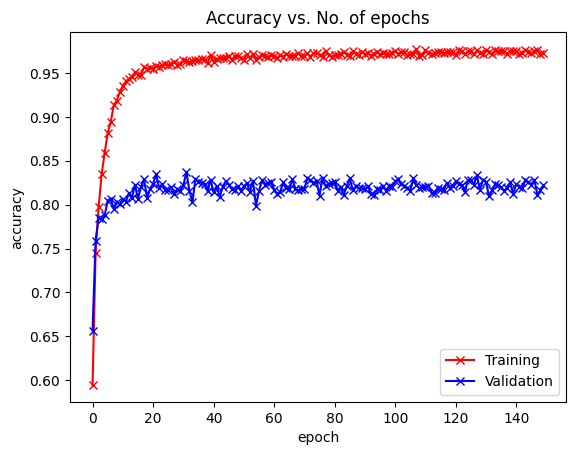

In [13]:
def plot_accuracies(history):
    Validation_accuracies = [x['Accuracy'] for x in history]
    Training_Accuracies = [x['train_accuracy'] for x in history]
    plt.plot(Training_Accuracies, '-rx')
    plt.plot(Validation_accuracies, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

training

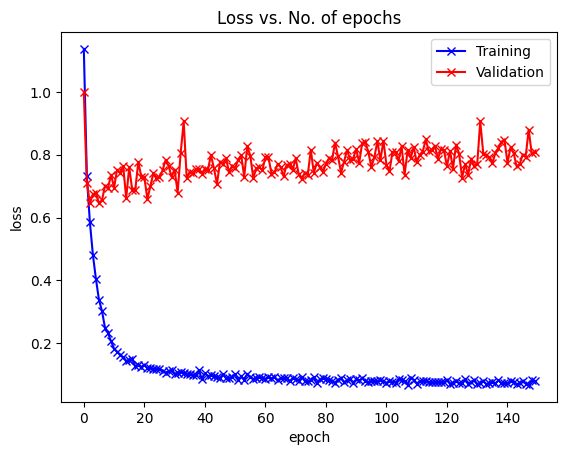

In [14]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['Loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)


Testing

In [15]:
test_loader = [(images.to(device), labels.to(device)) for images, labels in test_loader]
model.load_state_dict(torch.load(file_path))
model.to(device)

result = evaluate(model, test_loader)
print(f'Test Accuracy:{result["Accuracy"]*100:.2f}%')


Test Accuracy:82.57%


In [ ]:
RESNET56 FOR IMAGE CLASSIFICATION

In [16]:
class LambdaLayer(nn.Module):


    def __init__(self, lambd):

        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):

        return self.lambd(x)

class BasicConvBlock(nn.Module):



    def __init__(self, in_channels, out_channels, stride=1, option='A'):

        super(BasicConvBlock, self).__init__()

        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)),
            ('bn1', nn.BatchNorm2d(out_channels)),
            ('act1', nn.ReLU()),
            ('conv2', nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)),
            ('bn2', nn.BatchNorm2d(out_channels))
        ]))

        self.shortcut = nn.Sequential()


        if stride != 1 or in_channels != out_channels:
            if option == 'A':
                # Use identity shortcuts with zero padding to increase channel dimension.
                pad_to_add = out_channels//4


                self.shortcut = LambdaLayer(lambda x:
                            F.pad(x[:, :, ::2, ::2], (0,0, 0,0, pad_to_add, pad_to_add, 0,0)))
            if option == 'B':
                self.shortcut = nn.Sequential(OrderedDict([
                    ('s_conv1', nn.Conv2d(in_channels, 2*out_channels, kernel_size=1, stride=stride, padding=0, bias=False)),
                    ('s_bn1', nn.BatchNorm2d(2*out_channels))
                ]))

    def forward(self, x):

        out = self.features(x)
        # sum it up with shortcut layer
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [17]:
class ResNet(ImageClassificationBase):

    def __init__(self, block_type, num_blocks):
        super(ResNet, self).__init__()

        self.in_channels = 16

        self.conv0 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn0 = nn.BatchNorm2d(16)

        self.block1 = self.__build_layer(block_type, 16, num_blocks[0], starting_stride=1)

        self.block2 = self.__build_layer(block_type, 32, num_blocks[1], starting_stride=2)

        self.block3 = self.__build_layer(block_type, 64, num_blocks[2], starting_stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(64, 10)

    def __build_layer(self, block_type, out_channels, num_blocks, starting_stride):


        strides_list_for_current_block = [starting_stride] + [1]*(num_blocks-1)

        # print('strides_list_for_current_block ', strides_list_for_current_block)

        layers = []

        for stride in strides_list_for_current_block:
            layers.append(block_type(self.in_channels, out_channels, stride))
            self.in_channels = out_channels

        return nn.Sequential(*layers)

    def forward(self, x):

        out = F.relu(self.bn0(self.conv0(x)))
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.linear(out)
        return out

In [ ]:
from collections import OrderedDict
resnet =  ResNet(block_type=BasicConvBlock, num_blocks=[9,9,9])

resnet.to(device)
history = fit(resnet, train_loader, validation_loader)

100%|██████████| 704/704 [00:31<00:00, 22.61it/s]


Epoch : 1
Train Accuracy: 53.14% Validation Accuracy: 59.00%
Train Loss: 1.3029 Validation Loss: 1.1743


100%|██████████| 704/704 [00:30<00:00, 23.26it/s]


Epoch : 2
Train Accuracy: 69.16% Validation Accuracy: 60.36%
Train Loss: 0.8759 Validation Loss: 1.2089


100%|██████████| 704/704 [00:30<00:00, 23.17it/s]


Epoch : 3
Train Accuracy: 75.28% Validation Accuracy: 66.28%
Train Loss: 0.7095 Validation Loss: 0.9696


100%|██████████| 704/704 [00:30<00:00, 23.21it/s]


Epoch : 4
Train Accuracy: 78.74% Validation Accuracy: 70.63%
Train Loss: 0.6144 Validation Loss: 0.8477


100%|██████████| 704/704 [00:31<00:00, 22.61it/s]


Epoch : 5
Train Accuracy: 81.09% Validation Accuracy: 74.15%
Train Loss: 0.5478 Validation Loss: 0.7690


100%|██████████| 704/704 [00:30<00:00, 23.26it/s]


Epoch : 6
Train Accuracy: 82.94% Validation Accuracy: 72.84%
Train Loss: 0.4929 Validation Loss: 0.8888


100%|██████████| 704/704 [00:30<00:00, 23.29it/s]


Epoch : 7
Train Accuracy: 84.67% Validation Accuracy: 74.84%
Train Loss: 0.4479 Validation Loss: 0.7566


100%|██████████| 704/704 [00:30<00:00, 23.34it/s]


Epoch : 8
Train Accuracy: 85.83% Validation Accuracy: 76.44%
Train Loss: 0.4083 Validation Loss: 0.7266


100%|██████████| 704/704 [00:30<00:00, 23.31it/s]


Epoch : 9
Train Accuracy: 87.18% Validation Accuracy: 75.99%
Train Loss: 0.3696 Validation Loss: 0.7819


100%|██████████| 704/704 [00:30<00:00, 23.29it/s]


Epoch : 10
Train Accuracy: 88.33% Validation Accuracy: 75.71%
Train Loss: 0.3416 Validation Loss: 0.7526


100%|██████████| 704/704 [00:30<00:00, 23.29it/s]


Epoch : 11
Train Accuracy: 89.30% Validation Accuracy: 72.53%
Train Loss: 0.3104 Validation Loss: 0.9864


100%|██████████| 704/704 [00:30<00:00, 23.20it/s]


Epoch : 12
Train Accuracy: 90.18% Validation Accuracy: 78.18%
Train Loss: 0.2881 Validation Loss: 0.7260


100%|██████████| 704/704 [00:30<00:00, 23.30it/s]


Epoch : 13
Train Accuracy: 90.66% Validation Accuracy: 76.84%
Train Loss: 0.2695 Validation Loss: 0.7551


100%|██████████| 704/704 [00:30<00:00, 23.23it/s]


Epoch : 14
Train Accuracy: 91.44% Validation Accuracy: 77.18%
Train Loss: 0.2496 Validation Loss: 0.7391


100%|██████████| 704/704 [00:30<00:00, 23.26it/s]


Epoch : 15
Train Accuracy: 92.12% Validation Accuracy: 77.31%
Train Loss: 0.2295 Validation Loss: 0.8161


100%|██████████| 704/704 [00:30<00:00, 23.35it/s]


Epoch : 16
Train Accuracy: 92.52% Validation Accuracy: 77.39%
Train Loss: 0.2178 Validation Loss: 0.7860


100%|██████████| 704/704 [00:30<00:00, 23.32it/s]


Epoch : 17
Train Accuracy: 92.92% Validation Accuracy: 77.27%
Train Loss: 0.2044 Validation Loss: 0.8374


100%|██████████| 704/704 [00:30<00:00, 23.31it/s]


Epoch : 18
Train Accuracy: 93.16% Validation Accuracy: 77.89%
Train Loss: 0.1979 Validation Loss: 0.7951


100%|██████████| 704/704 [00:30<00:00, 23.29it/s]


Epoch : 19
Train Accuracy: 93.38% Validation Accuracy: 77.61%
Train Loss: 0.1904 Validation Loss: 0.8655


100%|██████████| 704/704 [00:30<00:00, 23.30it/s]


Epoch : 20
Train Accuracy: 93.57% Validation Accuracy: 75.87%
Train Loss: 0.1844 Validation Loss: 0.9855


100%|██████████| 704/704 [00:30<00:00, 23.30it/s]


Epoch : 21
Train Accuracy: 93.93% Validation Accuracy: 74.49%
Train Loss: 0.1736 Validation Loss: 0.9742


100%|██████████| 704/704 [00:30<00:00, 23.34it/s]


Epoch : 22
Train Accuracy: 94.08% Validation Accuracy: 75.53%
Train Loss: 0.1674 Validation Loss: 1.0012


100%|██████████| 704/704 [00:30<00:00, 23.39it/s]


Epoch : 23
Train Accuracy: 94.08% Validation Accuracy: 77.43%
Train Loss: 0.1685 Validation Loss: 0.8710


100%|██████████| 704/704 [00:30<00:00, 23.35it/s]


Epoch : 24
Train Accuracy: 94.42% Validation Accuracy: 77.85%
Train Loss: 0.1618 Validation Loss: 0.8544


100%|██████████| 704/704 [00:30<00:00, 23.39it/s]


Epoch : 25
Train Accuracy: 94.56% Validation Accuracy: 78.76%
Train Loss: 0.1548 Validation Loss: 0.7930


100%|██████████| 704/704 [00:30<00:00, 23.29it/s]


Epoch : 26
Train Accuracy: 94.30% Validation Accuracy: 76.72%
Train Loss: 0.1612 Validation Loss: 0.8953


100%|██████████| 704/704 [00:30<00:00, 23.22it/s]


Epoch : 27
Train Accuracy: 94.86% Validation Accuracy: 78.18%
Train Loss: 0.1483 Validation Loss: 0.8573


100%|██████████| 704/704 [00:30<00:00, 23.39it/s]


Epoch : 28
Train Accuracy: 94.72% Validation Accuracy: 77.45%
Train Loss: 0.1490 Validation Loss: 0.9181


100%|██████████| 704/704 [00:30<00:00, 23.27it/s]


Epoch : 29
Train Accuracy: 94.84% Validation Accuracy: 79.09%
Train Loss: 0.1451 Validation Loss: 0.7720


100%|██████████| 704/704 [00:30<00:00, 23.32it/s]


Epoch : 30
Train Accuracy: 94.80% Validation Accuracy: 76.70%
Train Loss: 0.1466 Validation Loss: 0.9383


100%|██████████| 704/704 [00:30<00:00, 23.35it/s]


Epoch : 31
Train Accuracy: 95.08% Validation Accuracy: 79.41%
Train Loss: 0.1431 Validation Loss: 0.7768


100%|██████████| 704/704 [00:30<00:00, 23.29it/s]


Epoch : 32
Train Accuracy: 95.09% Validation Accuracy: 76.11%
Train Loss: 0.1424 Validation Loss: 0.9019


100%|██████████| 704/704 [00:30<00:00, 23.37it/s]


Epoch : 33
Train Accuracy: 95.23% Validation Accuracy: 76.66%
Train Loss: 0.1369 Validation Loss: 0.9155


100%|██████████| 704/704 [00:30<00:00, 23.41it/s]


Epoch : 34
Train Accuracy: 95.18% Validation Accuracy: 76.54%
Train Loss: 0.1410 Validation Loss: 0.9791


100%|██████████| 704/704 [00:30<00:00, 23.37it/s]


Epoch : 35
Train Accuracy: 95.29% Validation Accuracy: 79.07%
Train Loss: 0.1346 Validation Loss: 0.8170


100%|██████████| 704/704 [00:30<00:00, 23.28it/s]


Epoch : 36
Train Accuracy: 95.12% Validation Accuracy: 77.93%
Train Loss: 0.1392 Validation Loss: 0.8551


100%|██████████| 704/704 [00:30<00:00, 23.45it/s]


Epoch : 37
Train Accuracy: 95.45% Validation Accuracy: 78.62%
Train Loss: 0.1319 Validation Loss: 0.8408


100%|██████████| 704/704 [00:30<00:00, 23.43it/s]


Epoch : 38
Train Accuracy: 95.43% Validation Accuracy: 78.50%
Train Loss: 0.1304 Validation Loss: 0.8362


100%|██████████| 704/704 [00:30<00:00, 23.38it/s]


Epoch : 39
Train Accuracy: 95.25% Validation Accuracy: 76.70%
Train Loss: 0.1350 Validation Loss: 0.9038


100%|██████████| 704/704 [00:30<00:00, 23.42it/s]


Epoch : 40
Train Accuracy: 95.45% Validation Accuracy: 76.72%
Train Loss: 0.1320 Validation Loss: 0.8993


100%|██████████| 704/704 [00:30<00:00, 23.30it/s]


Epoch : 41
Train Accuracy: 95.70% Validation Accuracy: 79.39%
Train Loss: 0.1268 Validation Loss: 0.8114


100%|██████████| 704/704 [00:30<00:00, 23.32it/s]


Epoch : 42
Train Accuracy: 95.43% Validation Accuracy: 78.03%
Train Loss: 0.1325 Validation Loss: 0.8375


100%|██████████| 704/704 [00:30<00:00, 23.35it/s]


Epoch : 43
Train Accuracy: 95.59% Validation Accuracy: 78.86%
Train Loss: 0.1267 Validation Loss: 0.8316


100%|██████████| 704/704 [00:30<00:00, 23.44it/s]


Epoch : 44
Train Accuracy: 95.73% Validation Accuracy: 78.66%
Train Loss: 0.1247 Validation Loss: 0.8330


100%|██████████| 704/704 [00:30<00:00, 23.38it/s]


Epoch : 45
Train Accuracy: 95.51% Validation Accuracy: 76.66%
Train Loss: 0.1281 Validation Loss: 0.9205


100%|██████████| 704/704 [00:30<00:00, 23.41it/s]


Epoch : 46
Train Accuracy: 95.46% Validation Accuracy: 78.46%
Train Loss: 0.1287 Validation Loss: 0.7977


100%|██████████| 704/704 [00:29<00:00, 23.53it/s]


Epoch : 47
Train Accuracy: 95.95% Validation Accuracy: 74.76%
Train Loss: 0.1156 Validation Loss: 1.0829


100%|██████████| 704/704 [00:30<00:00, 23.39it/s]


Epoch : 48
Train Accuracy: 95.54% Validation Accuracy: 77.14%
Train Loss: 0.1272 Validation Loss: 0.9592


100%|██████████| 704/704 [00:30<00:00, 23.45it/s]


Epoch : 49
Train Accuracy: 95.64% Validation Accuracy: 78.52%
Train Loss: 0.1256 Validation Loss: 0.8444


100%|██████████| 704/704 [00:29<00:00, 23.47it/s]


Epoch : 50
Train Accuracy: 95.81% Validation Accuracy: 79.33%
Train Loss: 0.1221 Validation Loss: 0.8362


100%|██████████| 704/704 [00:30<00:00, 23.43it/s]


Epoch : 51
Train Accuracy: 95.86% Validation Accuracy: 74.23%
Train Loss: 0.1208 Validation Loss: 1.1552


100%|██████████| 704/704 [00:30<00:00, 23.46it/s]


Epoch : 52
Train Accuracy: 95.72% Validation Accuracy: 77.55%
Train Loss: 0.1229 Validation Loss: 0.9009


100%|██████████| 704/704 [00:30<00:00, 23.44it/s]


Epoch : 53
Train Accuracy: 95.57% Validation Accuracy: 78.18%
Train Loss: 0.1260 Validation Loss: 0.8731


100%|██████████| 704/704 [00:30<00:00, 23.22it/s]


Epoch : 54
Train Accuracy: 95.84% Validation Accuracy: 77.73%
Train Loss: 0.1230 Validation Loss: 0.9182


100%|██████████| 704/704 [00:29<00:00, 23.49it/s]


Epoch : 55
Train Accuracy: 96.16% Validation Accuracy: 79.11%
Train Loss: 0.1142 Validation Loss: 0.8506


100%|██████████| 704/704 [00:30<00:00, 23.44it/s]


Epoch : 56
Train Accuracy: 95.79% Validation Accuracy: 77.85%
Train Loss: 0.1217 Validation Loss: 0.9080


100%|██████████| 704/704 [00:30<00:00, 23.46it/s]


Epoch : 57
Train Accuracy: 96.10% Validation Accuracy: 77.29%
Train Loss: 0.1133 Validation Loss: 0.8735


100%|██████████| 704/704 [00:30<00:00, 23.42it/s]


Epoch : 58
Train Accuracy: 95.93% Validation Accuracy: 79.29%
Train Loss: 0.1205 Validation Loss: 0.8076


100%|██████████| 704/704 [00:30<00:00, 23.46it/s]


Epoch : 59
Train Accuracy: 95.73% Validation Accuracy: 79.81%
Train Loss: 0.1213 Validation Loss: 0.7996


100%|██████████| 704/704 [00:30<00:00, 23.10it/s]


Epoch : 60
Train Accuracy: 96.11% Validation Accuracy: 78.84%
Train Loss: 0.1139 Validation Loss: 0.8866


100%|██████████| 704/704 [00:29<00:00, 23.53it/s]


Epoch : 61
Train Accuracy: 95.90% Validation Accuracy: 77.77%
Train Loss: 0.1178 Validation Loss: 0.8921


100%|██████████| 704/704 [00:29<00:00, 23.53it/s]


Epoch : 62
Train Accuracy: 96.05% Validation Accuracy: 77.59%
Train Loss: 0.1170 Validation Loss: 0.9321


100%|██████████| 704/704 [00:29<00:00, 23.48it/s]


Epoch : 63
Train Accuracy: 96.07% Validation Accuracy: 79.41%
Train Loss: 0.1138 Validation Loss: 0.8274


100%|██████████| 704/704 [00:29<00:00, 23.47it/s]


Epoch : 64
Train Accuracy: 95.99% Validation Accuracy: 77.10%
Train Loss: 0.1172 Validation Loss: 0.9343


100%|██████████| 704/704 [00:29<00:00, 23.52it/s]


Epoch : 65
Train Accuracy: 96.17% Validation Accuracy: 80.68%
Train Loss: 0.1120 Validation Loss: 0.7327


100%|██████████| 704/704 [00:30<00:00, 23.24it/s]


In [ ]:
test_loader = [(images.to(device), labels.to(device)) for images, labels in test_loader]
resnet.load_state_dict(torch.load(file_path))
resnet.to(device)

result = evaluate(resnet, test_loader)
print(f'Test Accuracy:{result["Accuracy"]*100:.2f}%')